# Simple ResNet Training for d=7 Surface Code

This notebook provides a simplified training pipeline for a ResNet decoder on d=7 surface code with 7 rounds.
- Single GPU training
- No W&B logging or resume logic
- Automatic batch size tuning
- Basic CSV logging for metrics

## 1. Setup and Imports

In [3]:
import sys
import os
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, IterableDataset
import lightning as L
from lightning.pytorch.tuner import Tuner
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger
import math
import random
from datetime import timedelta
from pathlib import Path
import logging

# Add src to path
sys.path.append('/n/home07/andigu/scale/src')

# Import custom modules
from resnet import ResNet3D
from dataset import TemporalSurfaceCodeDataset

# Enable optimizations
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.set_float32_matmul_precision('medium')

# Setup logging
logging.basicConfig(level=logging.INFO)
log = logging.getLogger(__name__)

print(f"PyTorch version: {torch.__version__}")
print(f"Lightning version: {L.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.7.1+cu126
Lightning version: 2.5.2
CUDA available: True
GPU: NVIDIA A100-SXM4-40GB MIG 3g.20gb


## 2. EMA Helper Class

In [2]:
class EMA:
    """Exponential Moving Average helper class."""
    def __init__(self, decay=0.999):
        self.decay = decay
        self.value = None
    
    def update(self, new_value):
        if self.value is None:
            self.value = new_value
        else:
            self.value = self.decay * self.value + (1 - self.decay) * new_value
        return self.value
    
    def get(self):
        return self.value if self.value is not None else 0.0

## 3. Simplified Lightning Module

In [3]:
import schedulefree

class ResNet3DTrainer(L.LightningModule):
    def __init__(self, 
                 d=7,
                 rounds=7,
                 architecture='resnet50',
                 embedding_dim=64,
                 lr=3e-4,
                 weight_decay=0.0,
                 num_embeddings=3):
        super().__init__()
        
        self.save_hyperparameters()
        self.lr = lr
        self.weight_decay = weight_decay
        
        # Create model
        self.model = ResNet3D(
            architecture=architecture,
            embedding_dim=embedding_dim,
            channel_multipliers=[2, 4, 8, 16],
            stage3_stride=(1, 1, 1),
            stage4_stride=(1, 1, 1),
            use_lstm=False,
            num_embeddings=num_embeddings
        )
        
        # Initialize metrics
        self.loss_ema = EMA(0.995)
        self.inacc_ema = EMA(0.995)
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y, (t_str, p_err) = batch
        pred = self.model(x)
        
        loss = F.binary_cross_entropy_with_logits(pred, y)
        
        # Track metrics
        loss_item = loss.item()
        inacc = ((pred > 0) != y).float().mean().item()
        
        self.loss_ema.update(loss_item)
        self.inacc_ema.update(inacc)
        
        # Log metrics
        self.log('loss', loss_item, on_step=True, prog_bar=False)
        self.log('loss_ema', self.loss_ema.get(), on_step=True, prog_bar=True)
        self.log('inacc_ema', self.inacc_ema.get(), on_step=True, prog_bar=True)
        
        return loss
    
    def configure_optimizers(self):
        optimizer = schedulefree.RAdamScheduleFree(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        optimizer.train()
        return optimizer

## 4. Simple Data Module

In [4]:
class SimpleDataModule(L.LightningDataModule):
    def __init__(self, d=7, rounds=7, p=2.1, batch_size=32, num_workers=4, mwpm_filter=False):
        super().__init__()
        self.d = d
        self.rounds = rounds
        self.p = p
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.mwpm_filter = mwpm_filter
        
    def train_dataloader(self):
        dataset = TemporalSurfaceCodeDataset(
            d=self.d,
            rounds=self.rounds,
            p=self.p,
            batch_size=self.batch_size,
            mwpm_filter=self.mwpm_filter,
            stage_manager=None,
            num_workers=self.num_workers,
            global_step_offset=0
        )
        
        def worker_init_fn(worker_id):
            worker_seed = torch.utils.data.get_worker_info().id
            np.random.seed(worker_seed)
            random.seed(worker_seed)
            torch.manual_seed(worker_seed)
        
        dataloader_kwargs = {
            'batch_size': None,  # Dataset handles batching
            'shuffle': False,
            'num_workers': self.num_workers,
            'pin_memory': True,
            'worker_init_fn': worker_init_fn
        }
        
        if self.num_workers > 0:
            dataloader_kwargs['prefetch_factor'] = 2
            dataloader_kwargs['persistent_workers'] = True
        
        return DataLoader(dataset, **dataloader_kwargs)

## 5. Training Configuration

In [5]:
# Fixed configuration for d=7 surface code
config = {
    # Dataset parameters
    'd': 7,
    'rounds': 7,
    'p': 1.75,
    'mwpm_filter': False,
    
    # Model parameters
    'architecture': 'resnet50',
    'embedding_dim': 64,
    'num_embeddings': 3,
    
    # Training parameters
    'lr': 1e-3,
    'weight_decay': 0.0,
    'max_steps': 10000,
    'log_every_n_steps': 50,
    'checkpoint_every_minutes': 15,
    
    # Hardware parameters
    'num_workers': 4,
    'precision': 'bf16-mixed',
    'gradient_clip_val': 1.0,
    
    # Output directory
    'output_dir': '/n/netscratch/yelin_lab/Everyone/andigu/scaling/d7_simple_notebook'
}

# Create output directory
output_dir = Path(config['output_dir'])
output_dir.mkdir(parents=True, exist_ok=True)
checkpoint_dir = output_dir / 'checkpoints'
checkpoint_dir.mkdir(exist_ok=True)
log_dir = output_dir / 'logs'
log_dir.mkdir(exist_ok=True)

print(f"Output directory: {output_dir}")
print(f"Configuration: {config}")

Output directory: /n/netscratch/yelin_lab/Everyone/andigu/scaling/d7_simple_notebook
Configuration: {'d': 7, 'rounds': 7, 'p': 1.75, 'mwpm_filter': False, 'architecture': 'resnet50', 'embedding_dim': 64, 'num_embeddings': 3, 'lr': 0.001, 'weight_decay': 0.0, 'max_steps': 10000, 'log_every_n_steps': 50, 'checkpoint_every_minutes': 15, 'num_workers': 4, 'precision': 'bf16-mixed', 'gradient_clip_val': 1.0, 'output_dir': '/n/netscratch/yelin_lab/Everyone/andigu/scaling/d7_simple_notebook'}


## 6. Initialize Model and Data Module

In [6]:
# Create model
model = ResNet3DTrainer(
    d=config['d'],
    rounds=config['rounds'],
    architecture=config['architecture'],
    embedding_dim=config['embedding_dim'],
    lr=config['lr'],
    weight_decay=config['weight_decay'],
    num_embeddings=config['num_embeddings']
)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Total parameters: 11,690,625
Trainable parameters: 11,690,625


## 7. Batch Size Tuning

In [7]:
# Create temporary data module for batch size tuning
temp_data_module = SimpleDataModule(
    d=config['d'],
    rounds=config['rounds'],
    p=config['p'],
    batch_size=2,  # Start with small batch size
    num_workers=config['num_workers'],
    mwpm_filter=config['mwpm_filter']
)

# Create tuning trainer (single GPU)
tuning_trainer = L.Trainer(
    accelerator='gpu',
    devices=1,
    precision=config['precision'],
    enable_checkpointing=False,
    logger=False
)

# Run batch size tuning
print("Running batch size tuning...")
tuner = Tuner(tuning_trainer)
tuner.scale_batch_size(
    model, 
    datamodule=temp_data_module, 
    mode="binsearch", 
    steps_per_trial=10
)

# Apply safety factor
optimal_batch_size = math.floor(temp_data_module.batch_size * 0.9)
print(f"Optimal batch size found: {temp_data_module.batch_size}")
print(f"Using batch size with safety factor: {optimal_batch_size}")

# Reset model metrics after tuning
model.loss_ema = EMA(0.995)
model.inacc_ema = EMA(0.995)

/n/home07/andigu/scale/.venv/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /n/home07/andigu/scale/.venv/lib/python3.12/site-pac ...
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/n/home07/andigu/scale/.venv/lib/python3.12/site-packages/lightning/pytorch/loops/utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-c09c7c27-9b0d-56f0-abdb-5d89f9c5b36c]


Running batch size tuning...


`Trainer.fit` stopped: `max_steps=10` reached.
Batch size 2 succeeded, trying batch size 4
`Trainer.fit` stopped: `max_steps=10` reached.
Batch size 4 succeeded, trying batch size 8
`Trainer.fit` stopped: `max_steps=10` reached.
Batch size 8 succeeded, trying batch size 16
`Trainer.fit` stopped: `max_steps=10` reached.
Batch size 16 succeeded, trying batch size 32
`Trainer.fit` stopped: `max_steps=10` reached.
Batch size 32 succeeded, trying batch size 64
`Trainer.fit` stopped: `max_steps=10` reached.
Batch size 64 succeeded, trying batch size 128
`Trainer.fit` stopped: `max_steps=10` reached.
Batch size 128 succeeded, trying batch size 256
`Trainer.fit` stopped: `max_steps=10` reached.
Batch size 256 succeeded, trying batch size 512
`Trainer.fit` stopped: `max_steps=10` reached.
Batch size 512 succeeded, trying batch size 1024
Batch size 1024 failed, trying batch size 768
Batch size 768 failed, trying batch size 640
Batch size 640 failed, trying batch size 576
Batch size 576 failed, t

Optimal batch size found: 572
Using batch size with safety factor: 514


## 8. Setup Training

In [8]:
# Create final data module with optimal batch size
data_module = SimpleDataModule(
    d=config['d'],
    rounds=config['rounds'],
    p=config['p'],
    batch_size=optimal_batch_size,
    num_workers=config['num_workers'],
    mwpm_filter=config['mwpm_filter']
)

# Setup logger
csv_logger = CSVLogger(
    save_dir=str(log_dir),
    name="",
    version=""
)

# Create trainer
trainer = L.Trainer(
    accelerator='gpu',
    devices=1,
    precision=config['precision'],
    max_steps=config['max_steps'],
    gradient_clip_val=config['gradient_clip_val'],
    gradient_clip_algorithm='norm',
    log_every_n_steps=config['log_every_n_steps'],
    logger=csv_logger,
    enable_progress_bar=True,
    enable_model_summary=True
)

print(f"\nTraining configuration:")
print(f"  Batch size: {optimal_batch_size}")
print(f"  Max steps: {config['max_steps']}")
print(f"  Learning rate: {config['lr']}")
print(f"  Precision: {config['precision']}")
print(f"  Gradient clipping: {config['gradient_clip_val']}")
print(f"  Checkpoint every: {config['checkpoint_every_minutes']} minutes")
print(f"  Log every: {config['log_every_n_steps']} steps")

Using bfloat16 Automatic Mixed Precision (AMP)
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Training configuration:
  Batch size: 514
  Max steps: 10000
  Learning rate: 0.001
  Precision: bf16-mixed
  Gradient clipping: 1.0
  Checkpoint every: 15 minutes
  Log every: 50 steps


## 9. Run Training

In [9]:
print("\n" + "="*50)
print("Starting training...")
print("="*50 + "\n")

# Train the model
trainer.fit(model=model, datamodule=data_module)

print("\n" + "="*50)
print("Training completed!")
print("="*50)

/n/home07/andigu/scale/.venv/lib/python3.12/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory /n/netscratch/yelin_lab/Everyone/andigu/scaling/d7_simple_notebook/logs/ exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-c09c7c27-9b0d-56f0-abdb-5d89f9c5b36c]

  | Name  | Type     | Params | Mode 
-------------------------------------------
0 | model | ResNet3D | 11.7 M | train
-------------------------------------------
11.7 M    Trainable params
0         Non-trainable params
11.7 M    Total params
46.762    Total estimated model params size (MB)
202       Modules in train mode
0         Modules in eval mode



Starting training...

Epoch 0: 100%|██████████| 10000/10000 [1:24:25<00:00,  1.97it/s, loss_ema=0.0459, inacc_ema=0.0169]

`Trainer.fit` stopped: `max_steps=10000` reached.


Epoch 0: 100%|██████████| 10000/10000 [1:24:25<00:00,  1.97it/s, loss_ema=0.0459, inacc_ema=0.0169]

Training completed!


# Inference

In [59]:
from simulate import Algorithm, SurfaceCode, NoiseModel, CodeFactory, StimSimulator, Pauli
import pandas as pd
from tqdm.auto import *

def generate_batch(d, rounds, p, batch_size):
    """Generate a single batch of surface code data."""
    # Create surface code circuit
    alg = Algorithm.build_memory(cycles=rounds)
    cf = CodeFactory(SurfaceCode, {'d': d})
    noise_model = NoiseModel.get_scaled_noise_model(p).without_loss()
    sim = StimSimulator(alg, noise_model, cf, seed=np.random.randint(0, 2**48))
    check_meta = pd.DataFrame(SurfaceCode.create_metadata(d).check)
    
    results = sim.sample(shots=batch_size)
    detectors = results.detectors
    logical_errors = results.logical_errors

    batch_size = len(detectors)
    # Initialize detector array
    det_array = np.zeros((batch_size, rounds+1, d+1, d+1), dtype=np.int32)

    # Process detector measurements
    det = pd.DataFrame(results.measurement_tracker.detectors)
    det = det.merge(check_meta, left_on='syndrome_id', right_on='check_id')
    det['time'] -= 1

    # Populate detector array
    time, x, y = det['time'].values, det['pos_x'].values, det['pos_y'].values
    det_id = det['check_type'].values[None,:]
    det_value = detectors[:, det['detector_id']]# * (det_id.max()+1) + det_id
    det_array[:, time, x, y] = (det_value + 1)

    return det_array, logical_errors.astype(np.float32), (rounds, p)


dec = torch.load("/n/netscratch/yelin_lab/Everyone/andigu/scaling/d7_simple_notebook/model.ckpt", weights_only=False)
dec = dec.cuda().eval()
all_embed, all_yhat, all_y = [], [], []
with torch.inference_mode():
    for _ in trange(40):
        x, y, _ = generate_batch(7, 7, 0.5, batch_size=512)
        xten = torch.from_numpy(x).cuda()
        embedding = dec.embedding(xten)
        embedding = torch.permute(embedding, (0, 4, 1, 2, 3))  # (batch, embedding_dim, time, height, width)
        all_embed.append(dec.stage3(dec.stage2(dec.stage1(embedding))).mean(dim=(-1,-2,-3)).cpu().numpy())
        yhat = dec(xten)
        yhat = yhat.cpu().numpy()
        all_yhat.append(yhat)
        all_y.append(y)
all_embed = np.concatenate(all_embed, axis=0)
all_yhat = np.concatenate(all_yhat, axis=0)
all_y = np.concatenate(all_y, axis=0)

100%|██████████| 40/40 [00:17<00:00,  2.26it/s]


In [60]:
import umap
reducer = umap.UMAP(densmap=True, n_components=2)
zembed = (all_embed - np.mean(all_embed, axis=0, keepdims=True))/np.std(all_embed, axis=0, keepdims=True)
transformed = reducer.fit_transform(zembed)

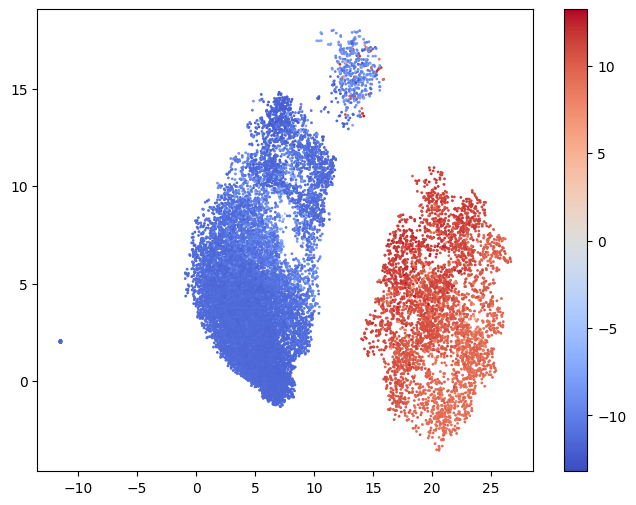

In [63]:
from matplotlib import pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(transformed[:,0], transformed[:,1], c=all_yhat, s=1, cmap='coolwarm')
plt.colorbar()

## 10. Load and Check Results

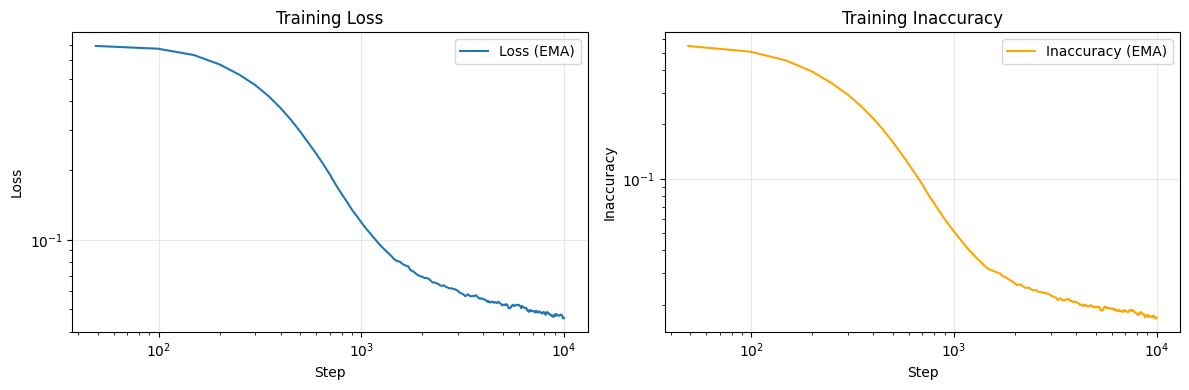


Final Metrics:
  Final Loss (EMA): 0.0459
  Final Inaccuracy (EMA): 0.0169
  Total steps: 9999

Checkpoints saved: 0


In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Load metrics from CSV
metrics_file = log_dir / 'metrics.csv'
if metrics_file.exists():
    df = pd.read_csv(metrics_file)
    
    # Plot loss and accuracy
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Loss plot
    if 'loss_ema' in df.columns:
        ax1.loglog(df['step'], df['loss_ema'], label='Loss (EMA)')
        ax1.set_xlabel('Step')
        ax1.set_ylabel('Loss')
        ax1.set_title('Training Loss')
        ax1.grid(True, alpha=0.3)
        ax1.legend()
    
    # Inaccuracy plot
    if 'inacc_ema' in df.columns:
        ax2.loglog(df['step'], df['inacc_ema'], label='Inaccuracy (EMA)', color='orange')
        ax2.set_xlabel('Step')
        ax2.set_ylabel('Inaccuracy')
        ax2.set_title('Training Inaccuracy')
        ax2.grid(True, alpha=0.3)
        ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print final metrics
    print("\nFinal Metrics:")
    print(f"  Final Loss (EMA): {df['loss_ema'].iloc[-1]:.4f}")
    print(f"  Final Inaccuracy (EMA): {df['inacc_ema'].iloc[-1]:.4f}")
    print(f"  Total steps: {df['step'].iloc[-1]}")
else:
    print("No metrics file found. Training may not have started.")

# List checkpoints
checkpoints = list(checkpoint_dir.glob('*.ckpt'))
print(f"\nCheckpoints saved: {len(checkpoints)}")
for ckpt in sorted(checkpoints)[-3:]:
    print(f"  - {ckpt.name}")

## 11. Optional: Test Model Inference

In [ ]:
# Test inference on a single batch
model.eval()
with torch.no_grad():
    # Get a single batch from the dataset
    dataset = TemporalSurfaceCodeDataset(
        d=config['d'],
        rounds=config['rounds'],
        p=config['p'],
        batch_size=32,
        mwpm_filter=False
    )
    
    # Get one batch
    batch_iter = iter(dataset)
    x, y, (t_str, p_err) = next(batch_iter)
    
    # Move to GPU if available
    if torch.cuda.is_available():
        x = torch.from_numpy(x).cuda()
        y = torch.from_numpy(y).cuda()
        model = model.cuda()
    else:
        x = torch.from_numpy(x)
        y = torch.from_numpy(y)
    
    # Forward pass
    pred = model(x)
    
    # Calculate metrics
    loss = F.binary_cross_entropy_with_logits(pred, y)
    accuracy = ((pred > 0) == y).float().mean()
    
    print(f"Test batch results:")
    print(f"  Batch shape: {x.shape}")
    print(f"  Prediction shape: {pred.shape}")
    print(f"  Loss: {loss.item():.4f}")
    print(f"  Accuracy: {accuracy.item():.4f}")
    print(f"  Error rate: {1 - accuracy.item():.4f}")